# Multi-security model for intraday volume forecasting

The intraday volume forecasting problem aims to predict future trading volume. 
One approach is to have a separate ML or statistical model for every security. 
This approach suffers from the complexity of managing multiple ML models and the inability to make 
forecasts for newly listed securities. Also, predictions for an individual security may benefit
from the information about other securities.

Following the winning strategies in the [M5 Competition](https://www.sciencedirect.com/science/article/pii/S0169207021001874), 
we train LightGBM on multiple securities while making security ID one of the features. We compare its performance to the models trained individually for each security and to a simple benchmark.

We find that the multi-security model performs as well as models trained on individual securities while offering the benefits of easier management and the ability to make forecasts for newly listed securities.

## Problem Definition

Predict trading volume for each of the given securities in the next 10 minutes.

Dataset:
- US equities trades/bars (NYSE TAQ) from 2022-02-10 to 2022-10-10
    - validation set from 2022-08-09 to 2022-09-08 
    - test set from 2022-09-09 to 2022-10-10

Input:
- past trading volume

Output:
- prediction for the next 10-minute period for each security

## Features

We limit our attention to the lagged values of trading volume for lags 1, 2, 3, 39, 40, the ID of the day's period (e.g., '9:30', '9:40', etc), and for the multi-symbols model, the ticker.

To illustrate the lag features: if it's 10am on a Tuesday, lag 1 carries the volume just traded between 9:50am and 10am, lag 39 is the volume traded Monday (yesterday) between 10am and 10:10am. (US trading day is six and a half hours between 9:30am and 4pm, which corresponds to 39 10-minute intervals).

The data set for a single security is illustrated below.

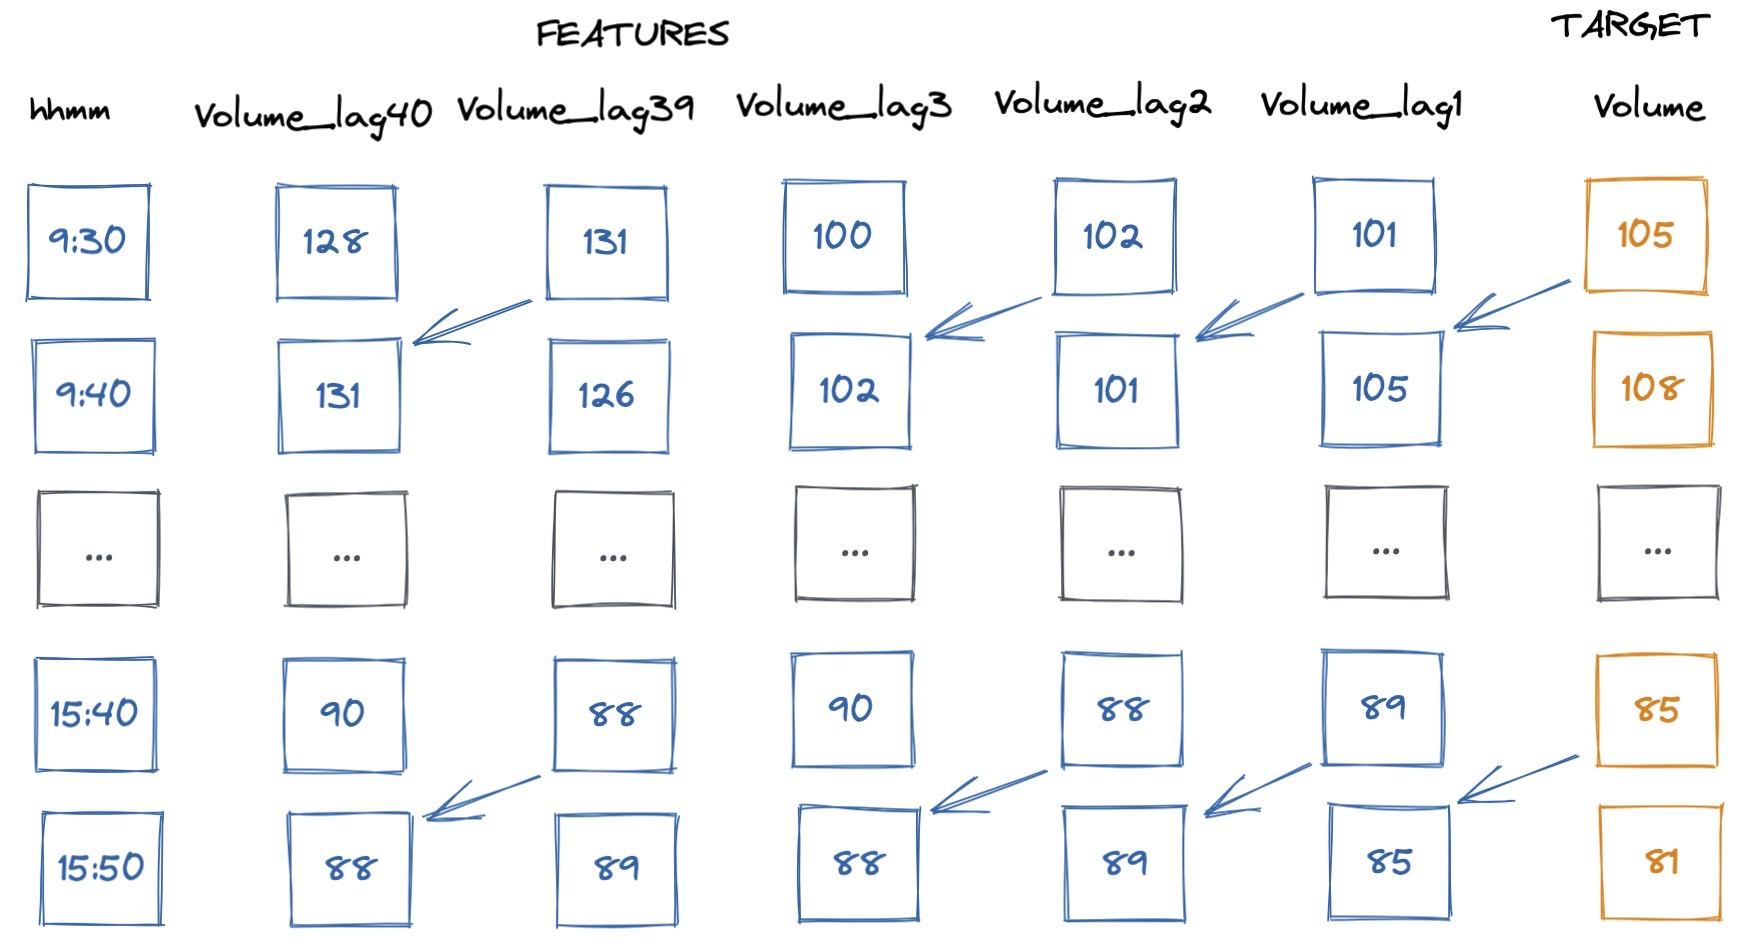

The data set with multiple securities stacks datasets with individual securities on top of each other and includes the 'ticker' feature.

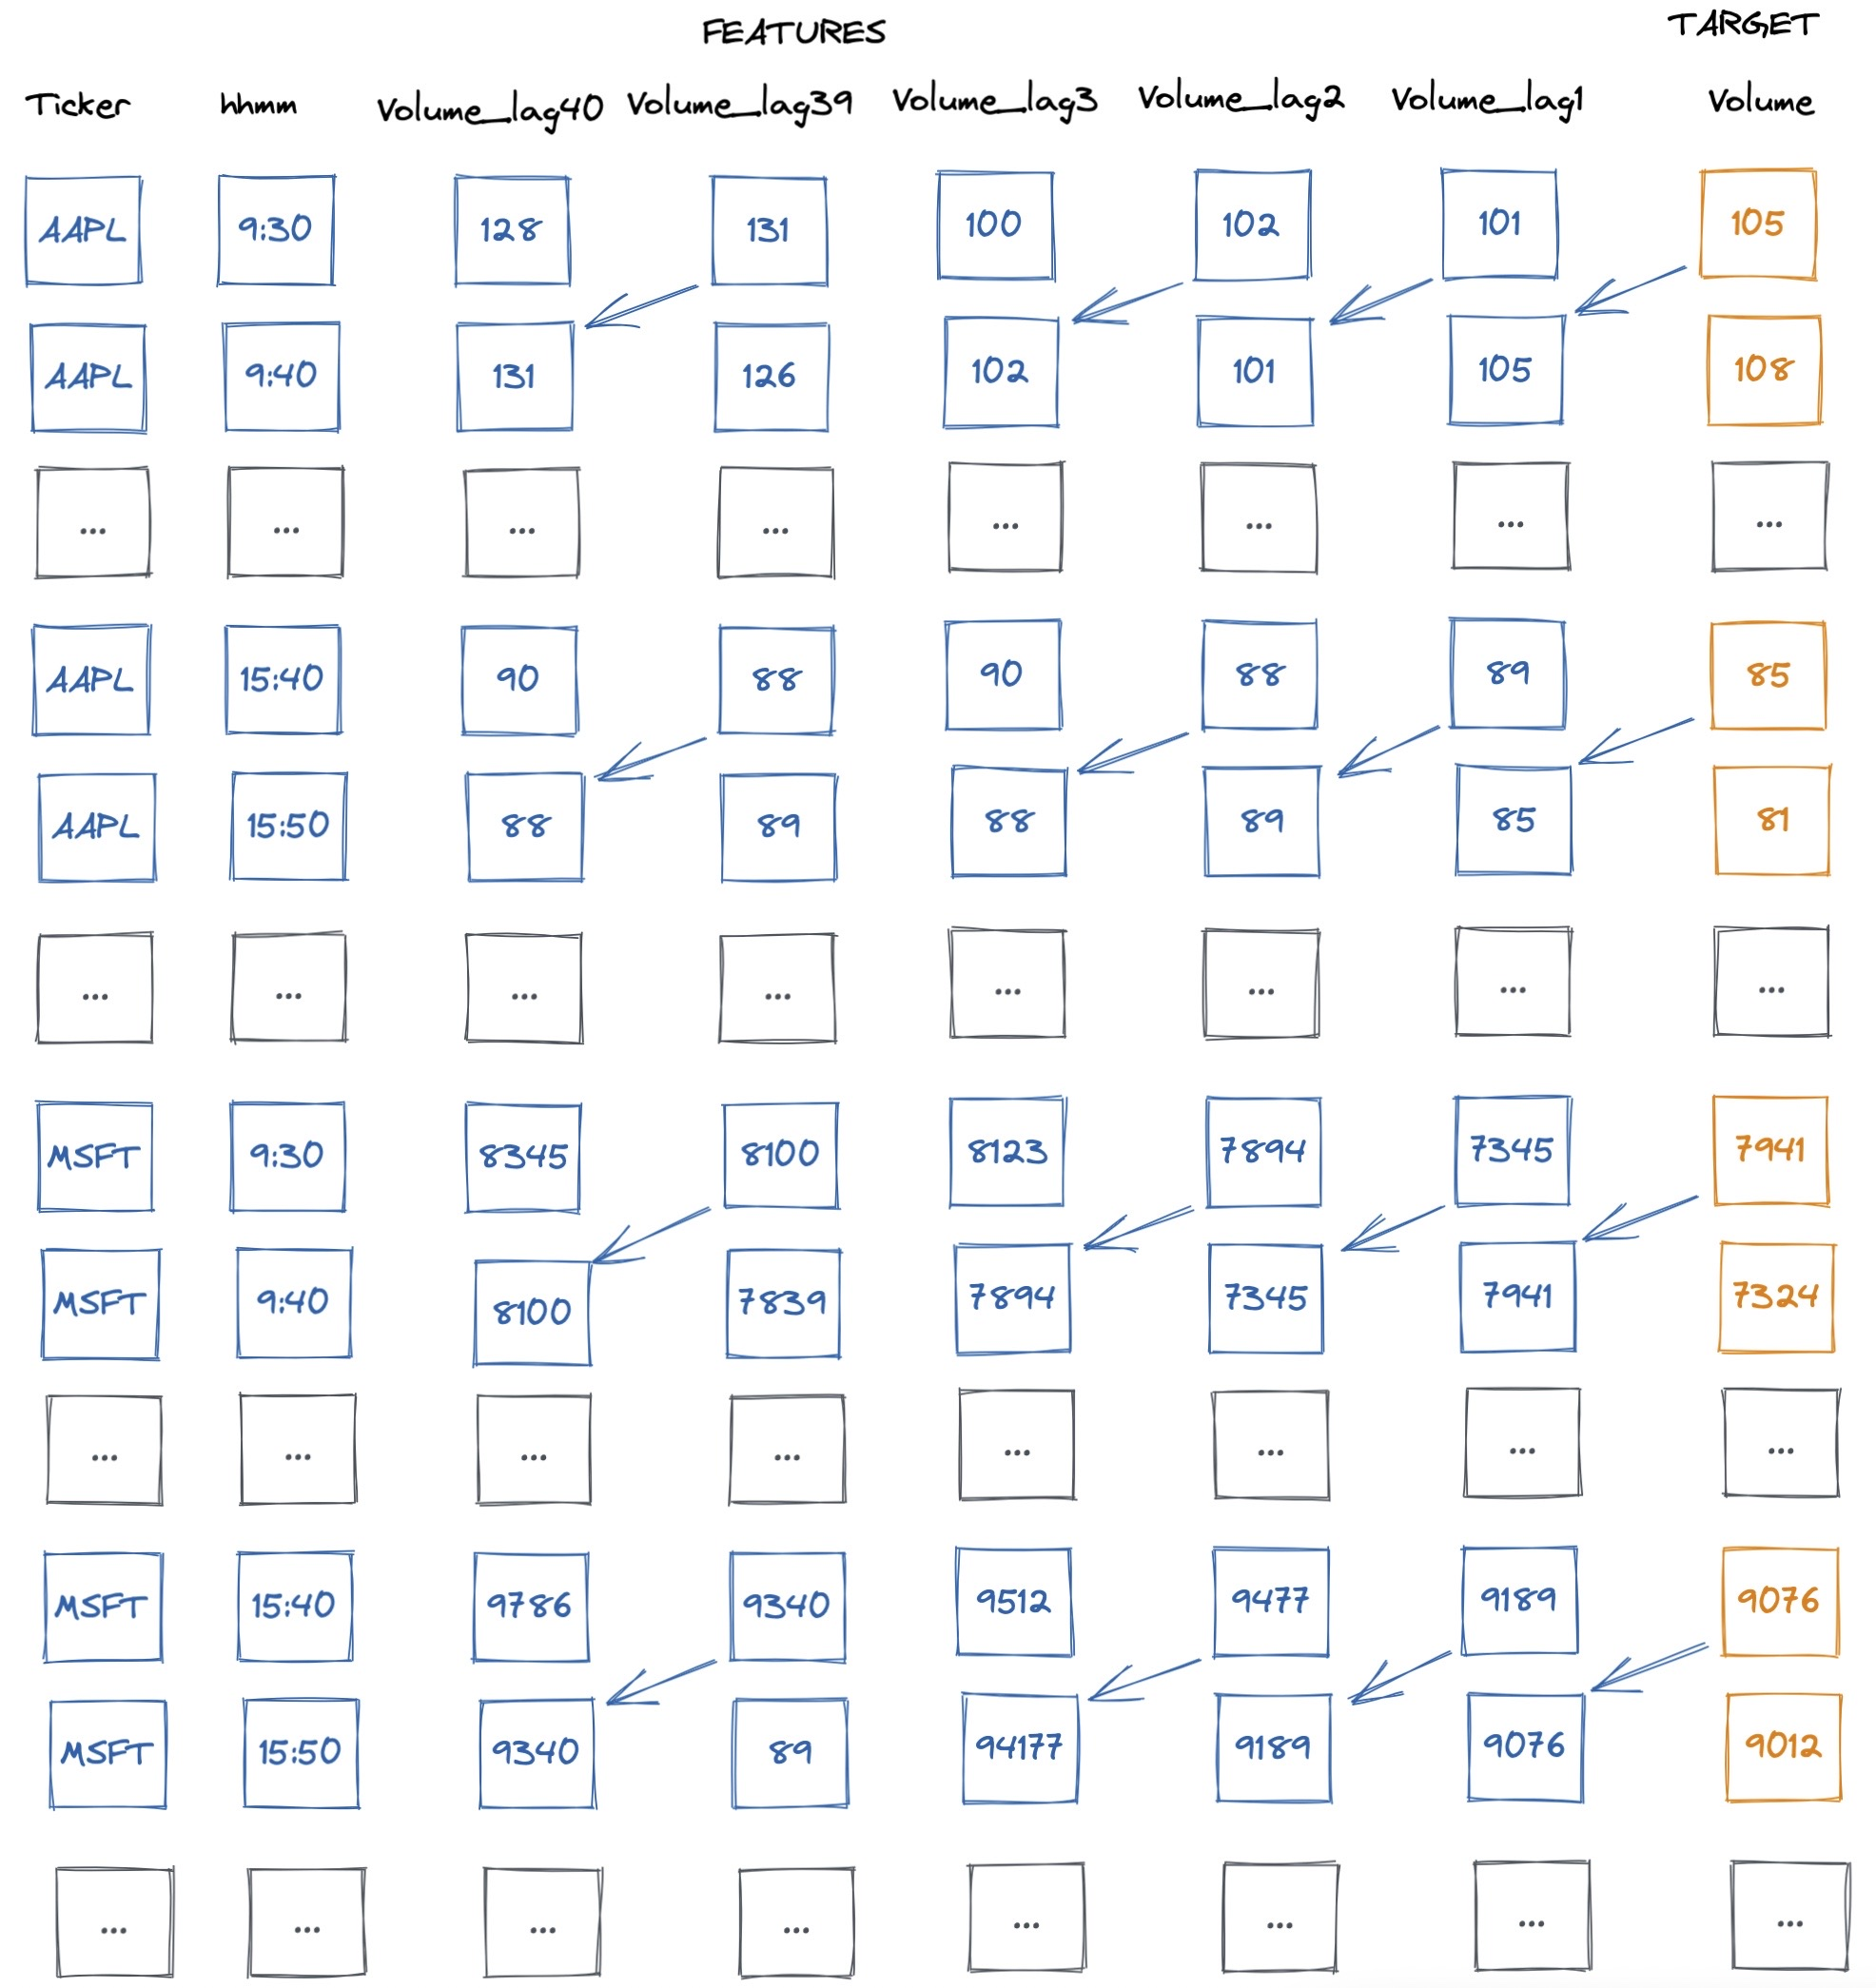

# Experimental setup

## ML model
LightGBM with the default parameters except for `boosting_type='dart'`. Experiment 3 includes a grid search over key hyperparameters for accuracy (num_leaves, max_depth, min_data_in_leaf).

## Validation
We train the model on the training set iteratively optimizing the loss function. We also compute the performance of the model in each iteration on the validation set according to the evaluation metric. We return the model from the iteration that resulted in the best value of the eval metric on the validation set.

## Preprocessing
We normalize volumes by the number of shares outstanding. The volumes are adjusted for corporate actions with the adjustment date and the number of shared outstanding as of the last day of the data set (2022-10-10).

## Benchmarks
A benchmark that returns the actual value for the last period as a prediction for the next one except for the first period of the day (9:30am-9:40am) for which the trading volume from the same interval of the previous trading day is used.


In [2]:
from sqlalchemy import create_engine
from scipy.stats import pearsonr
import pandas as pd
import plotly.express as px

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

eng = create_engine('sqlite:///vp.db')
all_metrics = pd.read_sql_table(table_name='metrics', con=eng)

## Experiment #1: Training models on sets of randomly selected S&P 500 securities

Our first experiment aims to gain statistically significant insights into the relative performance of single and multi-securies models.

- Repeat 50 times (for each experiment):
    - pick 50 securities uniformly at random from the S&P 500 securities
    - train the multi-security model on the picked securities
    - train 50 single-security models
    - for each security compute metrics on the test set for
        - the multi-security model
        - individually trained single-security model
        - the benchmark
- Compare the performance across 50 experiments and 50 securities

The metrics for multi-security and individual models are pretty similar and both are much better than the benchmark.

We compare both the means and the medians for each of the three competing models.

In [3]:
df = all_metrics[all_metrics['Experiment']=='ms_volnorm__os__hhmm_random50_50_v3']
df = df.merge(all_metrics[all_metrics['Experiment']=='ss_vol_hhmm_1_500'], on='TICKER', suffixes=('_multi', '_single'))
df = df.merge(all_metrics[all_metrics['Experiment']=='bm1_vol_hhmm_1_500'], on='TICKER')
df = df.rename(columns={'VOLUME_MAE_multi':'MAE multi','VOLUME_MAPE_multi':'MAPE multi', 'VOLUME_R2_multi':'R2 multi'})
df = df.rename(columns={'VOLUME_MAE_single':'MAE single','VOLUME_MAPE_single':'MAPE single', 'VOLUME_R2_single':'R2 single'})
df = df.rename(columns={'VOLUME_MAE':'MAE benchmark','VOLUME_MAPE':'MAPE benchmark', 'VOLUME_R2':'R2 benchmark'})

stats = df.describe(percentiles=[.025,.5,.975]).drop('count').T
stats = stats.rename(columns={'50%':'median'})

stats['ci_std_lower'] = stats['mean'] - 1.96 * stats['std']
stats['ci_std_upper'] = stats['mean'] + 1.96 * stats['std']
stats['ci_perc_lower'] = stats['2.5%']
stats['ci_perc_upper'] = stats['97.5%']

In [4]:
px.bar(stats.loc[['MAE benchmark', 'MAE multi', 'MAE single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group',
       title='MAE comparison (the lower the better)')

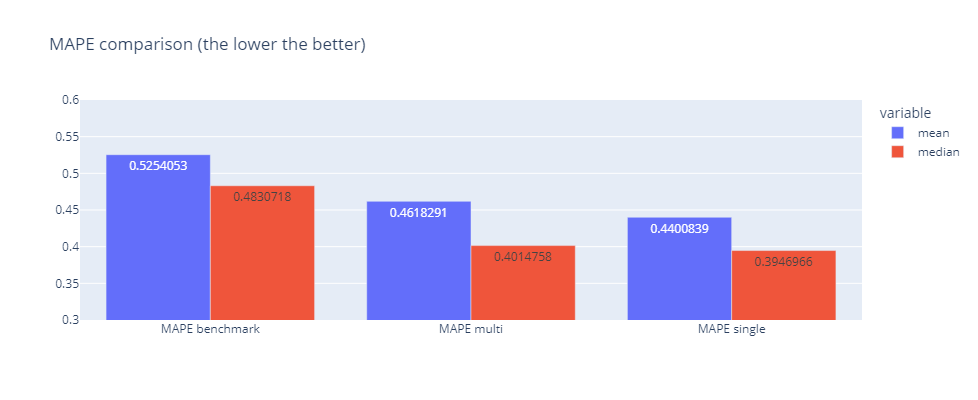

In [5]:
# px.bar(qdf.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']], y=['mean', 'median'], height=400,
#        labels={'index':'', 'value':''}, barmode='group',
#        title='MAPE comparison (the lower the better)').update_traces(
#     error_y={
#         "type": "data",
#         "symmetric": False,
#         "array": stats.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']]["ci_std_upper"] - stats.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']]["mean"],
#         "arrayminus": stats.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']]["mean"] - stats.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']]["ci_std_lower"],
#     }
# )

px.bar(stats.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text_auto=True, range_y=[0.3, 0.6],
       title='MAPE comparison (the lower the better)')

In [6]:
px.bar(stats.loc[['R2 benchmark', 'R2 multi', 'R2 single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text_auto=True,
       title='R2 comparison (the higher the better)')

Next, we take a closer look at the relative performance of the multi and single models.

- for each experiment:
    - for each security:
        - compute the difference between the metrics of multi and single models
            - MAPE: delta = single - multi
            - R2: delta = multi - single
            - positive values of delta reflect better performance of multi over single
        
We can see that the performance of the models is nearly identical: we cannot conclude that either one is better.

The 95% confidence intervals below for MAPE and R2 are roughly centered around zero.

In [7]:
# print('Delta reflects the advantage of multi models over single models:\n')
df['MAPE delta'] = df['MAPE single'] - df['MAPE multi']
df['MAE delta'] = df['MAE single'] - df['MAE multi']
df['R2 delta'] = df['R2 multi'] - df['R2 single']
df['MAPE bench-single'] = df['MAPE benchmark'] - df['MAPE single']
df['MAE bench-single'] = df['MAE benchmark'] - df['MAE single']
df['R2 single-bench'] = df['R2 single'] - df['R2 benchmark']
prev_stats = stats.copy(deep=True)
stats = df[['MAPE delta', 'R2 delta', 'MAE delta', 
            'MAPE bench-single', 'R2 single-bench', 'MAE bench-single']].describe(percentiles=[.025,.5,.975]).drop('count')

In [8]:
stats.loc[['mean', 'std'], 'MAE delta relative'] = \
    stats.loc[['mean', 'std'], 'MAE delta']/prev_stats.loc['MAE multi', 'mean']
stats.loc[['2.5%', '50%', '97.5%'], 'MAE delta relative'] = \
    stats.loc[['2.5%', '50%', '97.5%'], 'MAE delta'] / prev_stats.loc['MAE multi', 'median']

ci_mean = {'mean':[], 'ci_lower':[], 'ci_upper':[]}
ci_median = {'median':[], 'ci_lower':[], 'ci_upper':[]}
for idx in ['MAPE delta', 'R2 delta', 'MAE delta relative']:
    ci_mean['mean'].append(stats.loc['mean', idx])
    ci_mean['ci_lower'].append(stats.loc['mean', idx] - 1.96 * stats.loc['std', idx])
    ci_mean['ci_upper'].append(stats.loc['mean', idx] + 1.96 * stats.loc['std', idx])
    ci_median['median'].append(stats.loc['50%', idx])
    ci_median['ci_lower'].append(stats.loc['2.5%', idx])
    ci_median['ci_upper'].append(stats.loc['97.5%', idx])

ci_mean_df = pd.DataFrame(ci_mean, index=['MAPE delta', 'R2 delta', 'MAE delta relative'])

# print('----------\nConfidence interval of the form: mean(metric) +- 1.96 * stddev(metric):\n')
# for idx in ['VOLUME_MAPE_delta', 'VOLUME_R2_delta', 'VOLUME_MAE_delta_relative']:
#     print(f"{idx}, mean: {round(ci_mean_df.loc[idx, 'mean'], 4)}, 95% conf interval: [" \
#           f"{round(ci_mean_df.loc[idx, 'ci_lower'], 4)} , " \
#           f"{round(ci_mean_df.loc[idx, 'ci_upper'], 4)}]")
# print('\nwhere VOLUME_MAE_delta_relative = VOLUME_MAE_delta / mean(VOLUME_MAE_multi)\n----------')

ci_median_df = pd.DataFrame(ci_median, index=['MAPE delta', 'R2 delta', 'MAE delta relative'])

# print('----------\nConfidence interval of the form: 2.5% - 97.5% percentiles range:\n')
# for idx in ['VOLUME_MAPE_delta', 'VOLUME_R2_delta', 'VOLUME_MAE_delta_relative']:
#     print(f"{idx}, median: {round(ci_median_df.loc[idx, 'median'], 4)}, 95% conf interval: [" \
#           f"{round(ci_median_df.loc[idx, 'ci_lower'], 4)} , " \
#           f"{round(ci_median_df.loc[idx, 'ci_upper'], 4)}]")
# print('\nwhere VOLUME_MAE_delta_relative = VOLUME_MAE_delta / median(VOLUME_MAE_multi)\n----------')
ci_mean_df = ci_mean_df.loc[['MAPE delta','R2 delta']].reset_index().rename(columns={'index':'metric'})
ci_median_df = ci_median_df.loc[['MAPE delta','R2 delta']].reset_index().rename(columns={'index':'metric'})

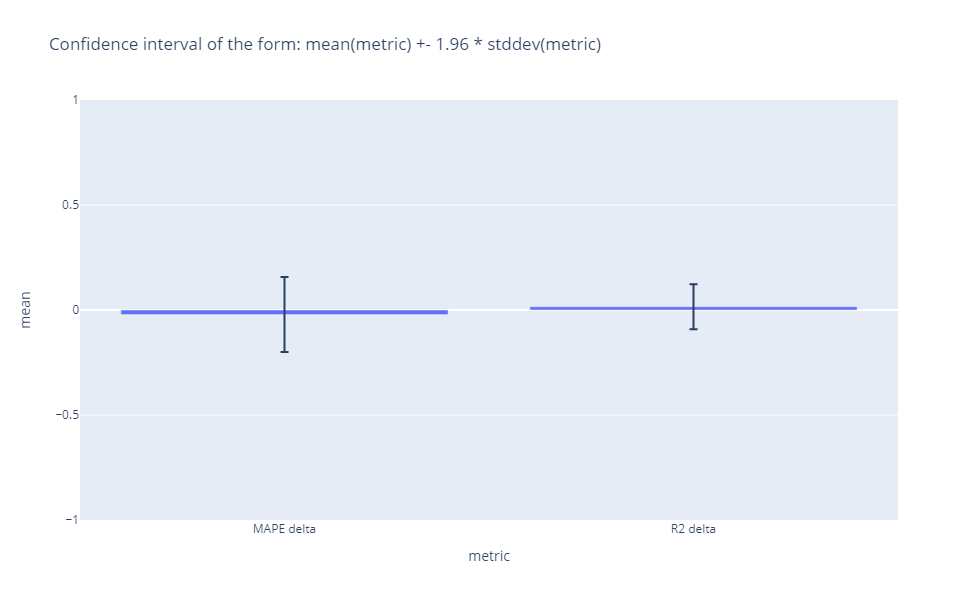

In [9]:
px.bar(ci_mean_df, x="metric", y="mean", range_y=[-1, 1], height=600,
      title='Confidence interval of the form: mean(metric) +- 1.96 * stddev(metric)').update_traces(
    error_y={
        "type": "data",
        "symmetric": False,
        "array": ci_mean_df["ci_upper"] - ci_mean_df["mean"],
        "arrayminus": ci_mean_df["mean"] - ci_mean_df["ci_lower"],
    }
)

We include intervals based on percentiles as well.

In [10]:
px.bar(ci_median_df, x="metric", y="median", range_y=[-1, 1], height=600,
      title='Confidence interval of the form: 2.5% - 97.5% percentiles range').update_traces(
    error_y={
        "type": "data",
        "symmetric": False,
        "array": ci_median_df["ci_upper"] - ci_median_df["median"],
        "arrayminus": ci_median_df["median"] - ci_median_df["ci_lower"],
    }
)

In [11]:
ci2_mean = {'mean':[], 'ci_lower':[], 'ci_upper':[]}
ci2_median = {'median':[], 'ci_lower':[], 'ci_upper':[]}
for idx in ['MAPE bench-single', 'R2 single-bench', 'MAE bench-single']:
    ci2_mean['mean'].append(stats.loc['mean', idx])
    ci2_mean['ci_lower'].append(stats.loc['mean', idx] - 1.96 * stats.loc['std', idx])
    ci2_mean['ci_upper'].append(stats.loc['mean', idx] + 1.96 * stats.loc['std', idx])
    ci2_median['median'].append(stats.loc['50%', idx])
    ci2_median['ci_lower'].append(stats.loc['2.5%', idx])
    ci2_median['ci_upper'].append(stats.loc['97.5%', idx])

ci2_mean_df = pd.DataFrame(ci2_mean, index=['MAPE bench-single', 'R2 single-bench', 'MAE bench-single'])

ci2_median_df = pd.DataFrame(ci2_median, index=['MAPE bench-single', 'R2 single-bench', 'MAE bench-single'])

ci2_mean_df = ci2_mean_df.loc[['MAPE bench-single', 'R2 single-bench']].reset_index().rename(columns={'index':'metric'})
ci2_median_df = ci2_median_df.loc[['MAPE bench-single', 'R2 single-bench']].reset_index().rename(columns={'index':'metric'})

We contrast the relative performance of multi and single discussed above with the relative performance of benchmark vs single and benchmark vs multi.

The relative performance of the benchmark model and the single model show that the single model is likely to outperform the benchmark. The 95% confidence interval for the difference in performance is above zero for R2 and barely crosses zero for MAPE. 

In [12]:
px.bar(ci2_mean_df, x="metric", y="mean", range_y=[-1, 1], height=600,
      title='Confidence interval of the form: mean(metric) +- 1.96 * stddev(metric)').update_traces(
    error_y={
        "type": "data",
        "symmetric": False,
        "array": ci2_mean_df["ci_upper"] - ci2_mean_df["mean"],
        "arrayminus": ci2_mean_df["mean"] - ci2_mean_df["ci_lower"],
    }
)

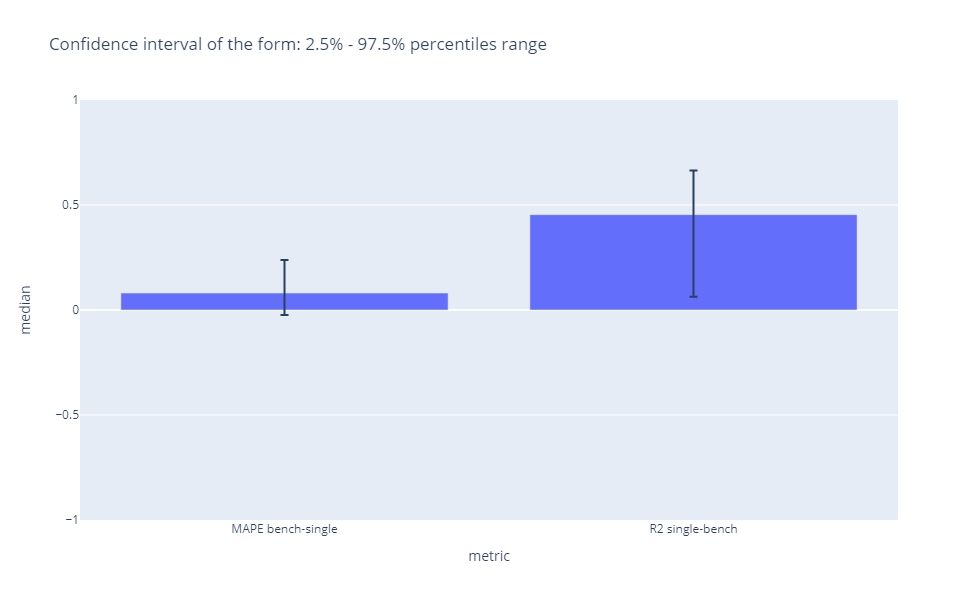

In [13]:
px.bar(ci2_median_df, x="metric", y="median", range_y=[-1, 1], height=600,
      title='Confidence interval of the form: 2.5% - 97.5% percentiles range').update_traces(
    error_y={
        "type": "data",
        "symmetric": False,
        "array": ci2_median_df["ci_upper"] - ci2_median_df["median"],
        "arrayminus": ci2_median_df["median"] - ci2_median_df["ci_lower"],
    }
)

## Experiment #2: Applying trained multi-security model to new securities

Our second experiment explores the performance of a multi-security model on securities that it was not trained on. This allows, for example, making predictions for newly listed securities.

We measure the quality of such predictions relative to the predictions made by the multi-security model with all symbols present and relative to the predictions of single-security models.

We take the top 50 S&P 500 symbols by market cap, train a multi-security model on them, remove 5 symbols from the set, and train another multi-symbol model on the remaining 45 symbols. We also train 5 single-symbol models on the corresponding symbols. We then make forecasts for the 5 symbols using the three models above.

The other parameters of the experiment remain the same.

We removed securities 23-27 (tickers: ABBV, KO, MRK, ORCL, PEP) for the results reported below. Removing randomly selected securities produced similar results. We are running more experiments on clustering/prediction for unseen securities.

The table below summarizes the results for the 5 removed securities. The metrics for "multi with all symbols" and "multi with removed symbols" are similar for all 5 securities. The metrics for the single-secuity model are also similar on all symbols except PEP where the single-security model has better MAPE and MAE values. We intend to investigate the cause of this further as part of the research on how clustering of symbols affects the performance of multi-symbol models (i.e., training models on clusters of "similar" securities is likely to work best for making forecasts about securities from the same cluster).


In [14]:
all_ss_df = all_metrics[all_metrics['Experiment']=='ms_volnorm__os__hhmm_1_50']
experiments = ['ns_volnorm__os__hhmm_1_50']

res = {}
for experiment in experiments:
    cluster_df = all_metrics[all_metrics['Experiment']==experiment]
    cluster_symbols = pd.unique(cluster_df['TICKER'])
    res = cluster_df.merge(all_ss_df[all_ss_df['TICKER'].isin(cluster_symbols)], 
                           on='TICKER', 
                           suffixes=('_multi_with_removed_symbols', '_multi_with_all_symbols')).set_index('TICKER')
    res = res.join(all_metrics[all_metrics['Experiment']=='ss_vol_hhmm_1_500'].set_index('TICKER'))
    res = res.rename(columns={'VOLUME_MAPE':'VOLUME_MAPE_single',
                              'VOLUME_MAE':'VOLUME_MAE_single',
                              'VOLUME_R2':'VOLUME_R2_single'}).T
    res = res.drop(['Experiment_multi_with_removed_symbols', 'Experiment_multi_with_all_symbols', 'Experiment']).sort_index()

res

TICKER                                          ABBV            KO  \
VOLUME_MAE_multi_with_all_symbols       25153.780826  56921.020726   
VOLUME_MAE_multi_with_removed_symbols   25112.567581  57321.391253   
VOLUME_MAE_single                       25455.300288  58887.463597   
VOLUME_MAPE_multi_with_all_symbols          0.274737      0.230725   
VOLUME_MAPE_multi_with_removed_symbols      0.274567      0.231388   
VOLUME_MAPE_single                          0.280187      0.238894   
VOLUME_R2_multi_with_all_symbols            0.629081       0.79695   
VOLUME_R2_multi_with_removed_symbols        0.631266      0.794273   
VOLUME_R2_single                            0.647347      0.780322   

TICKER                                           MRK          ORCL  \
VOLUME_MAE_multi_with_all_symbols       31698.044653  49068.055985   
VOLUME_MAE_multi_with_removed_symbols   32499.821477  48649.569728   
VOLUME_MAE_single                        32060.28768  50923.847085   
VOLUME_MAPE_multi_with_all_symbols           0.25745      0.251175   
VOLUME_MAPE_multi_with_removed_symbols      0.262986      0.252041   
VOLUME_MAPE_single                          0.264761      0.251311   
VOLUME_R2_multi_with_all_symbols            0.693728      0.662273   
VOLUME_R2_multi_with_removed_symbols        0.698449      0.678591   
VOLUME_R2_single                            0.694117      0.730718   

TICKER                                           PEP  
VOLUME_MAE_multi_with_all_symbols       16183.697647  
VOLUME_MAE_multi_with_removed_symbols   16293.533104  
VOLUME_MAE_single                       15837.497425  
VOLUME_MAPE_multi_with_all_symbols          0.287351  
VOLUME_MAPE_multi_with_removed_symbols      0.288899  
VOLUME_MAPE_single                          0.266603  
VOLUME_R2_multi_with_all_symbols            0.735297  
VOLUME_R2_multi_with_removed_symbols        0.731215  
VOLUME_R2_single                            0.744493

The results for the model with removed symbols are encouraging for the use case of forecasing volumes for newly listed symbols.


## Experiment #3: Train model on all S&P 500 symbols

This experiment includes all tickers of S&P 500. By design, the multi-security model trains on 500 times more data than each of the 500 single-security models. We perform a grid search over some of the key model hyperparameters. We discuss hyperparameter tuning in more details in Experiment #4.
The other parameters of the experiment remain the same.

In [15]:
df = all_metrics[all_metrics['Experiment']=='ms_volnorm__os__hhmm_1_500_optimized_v4']
df = df.merge(all_metrics[all_metrics['Experiment']=='ss_vol_hhmm_1_500_optimized_all'], on='TICKER', suffixes=('_multi', '_single'))
df = df.merge(all_metrics[all_metrics['Experiment']=='bm1_vol_hhmm_1_500'], on='TICKER')
df = df.rename(columns={'VOLUME_MAE_multi':'MAE multi','VOLUME_MAPE_multi':'MAPE multi', 'VOLUME_R2_multi':'R2 multi'})
df = df.rename(columns={'VOLUME_MAE_single':'MAE single','VOLUME_MAPE_single':'MAPE single', 'VOLUME_R2_single':'R2 single'})
df = df.rename(columns={'VOLUME_MAE':'MAE benchmark','VOLUME_MAPE':'MAPE benchmark', 'VOLUME_R2':'R2 benchmark'})

qdf = pd.DataFrame(df.quantile(0.5).sort_index())
mdf = pd.DataFrame(df.mean(numeric_only=True))
qdf = qdf.join(mdf)
qdf.columns = ['median', 'mean']

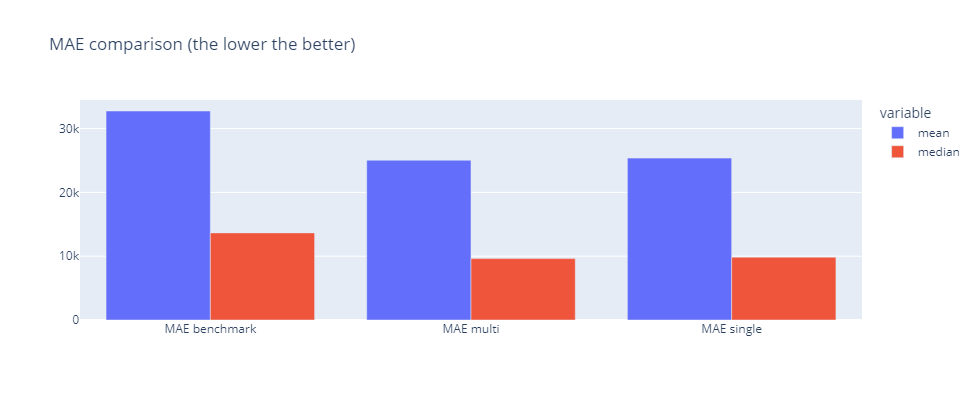

In [16]:
px.bar(qdf.loc[['MAE benchmark', 'MAE multi', 'MAE single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group', 
       title='MAE comparison (the lower the better)')

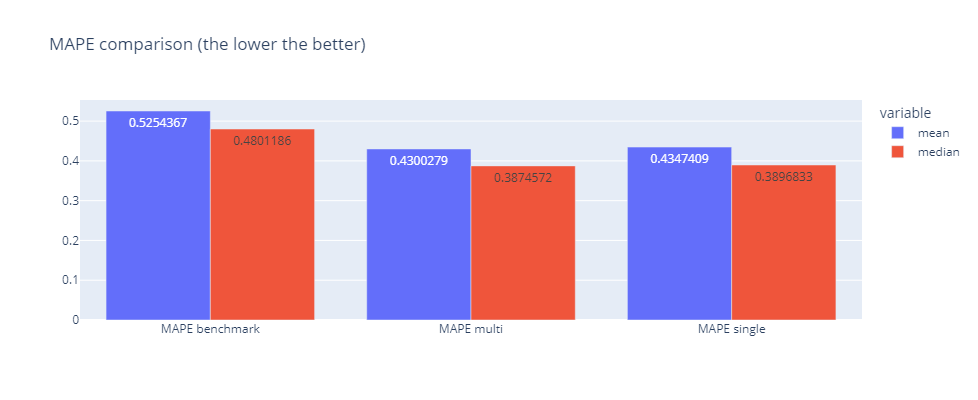

In [17]:
px.bar(qdf.loc[['MAPE benchmark', 'MAPE multi', 'MAPE single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text_auto=True,
       title='MAPE comparison (the lower the better)')

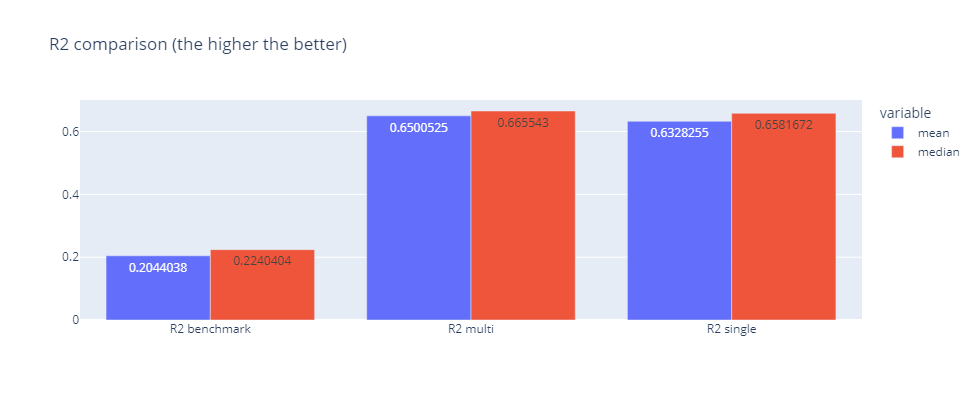

In [18]:
px.bar(qdf.loc[['R2 benchmark', 'R2 multi', 'R2 single']], y=['mean', 'median'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text_auto=True,
       title='R2 comparison (the higher the better)')

Encouragingly for the multi-security model, the metrics for both approaches turned out to be almost the same.

## Experiment #4: Compare training models with and without hyperparameter optimization (on the top 100 S&P 500 symbols)

We tuned the values of num_leaves, max_depth, min_data_in_leaf for the single and multi security models.

Hyperparameter tuning was important for the multi-security model: in particular, the tuned model resulted in much lower MAPE values. R2 was not improved by much. There was little benefit in tuning for the single-security models. Our intuition is that simpler single-security models work well with the default parameters while a much more complicated (in terms of the input data) multi-security models benefit from tuning.

In [19]:
experiments = ['ms_volnorm__os__hhmm_1_100']

res = {}
for opt in ['', '_optimized']:
    experiment = f'{experiments[0]}{opt}'
    all_ss_df = all_metrics[all_metrics['Experiment']==f'ss_vol_hhmm_1_500{opt}']
    cluster_df = all_metrics[all_metrics['Experiment']==experiment]
    cluster_symbols = pd.unique(cluster_df['TICKER'])
    res[experiment]={}
    res[experiment][f'median multi'] = cluster_df.quantile(0.5).values
    res[experiment][f'mean multi'] = cluster_df.mean(numeric_only=True).values
    res[f's{experiment[1:]}']={}
    res[f's{experiment[1:]}'][f'median single'] = all_ss_df[all_ss_df['TICKER'].isin(cluster_symbols)].quantile(0.5).values
    res[f's{experiment[1:]}'][f'mean single'] = all_ss_df[all_ss_df['TICKER'].isin(cluster_symbols)].mean(numeric_only=True).values
    
res_df = pd.concat([pd.DataFrame(res['ms_volnorm__os__hhmm_1_100'], index=['MAPE','MAE','R2']).T,
                    pd.DataFrame(res['ss_volnorm__os__hhmm_1_100'], index=['MAPE','MAE','R2']).T,
                    ]
                  )

res2_df = pd.concat([pd.DataFrame(res['ms_volnorm__os__hhmm_1_100_optimized'], index=['MAPE','MAE','R2']).T,
                    pd.DataFrame(res['ss_volnorm__os__hhmm_1_100_optimized'], index=['MAPE','MAE','R2']).T]
                  )

res_df = res_df.join(res2_df, lsuffix=' without optimization', rsuffix=' with optimization').T

res_df

median multi    mean multi  median single  \
MAPE without optimization      0.320513      0.351246       0.287135   
MAE without optimization   24929.431984  47710.219711   25508.886681   
R2 without optimization        0.675362      0.663805       0.659462   
MAPE with optimization         0.278284      0.309935       0.285122   
MAE with optimization      24235.796388  47437.613351   25117.212072   
R2 with optimization           0.664540      0.659203       0.658584   

                            mean single  
MAPE without optimization      0.312728  
MAE without optimization   48290.901289  
R2 without optimization        0.644393  
MAPE with optimization         0.310425  
MAE with optimization      48020.026438  
R2 with optimization           0.644761

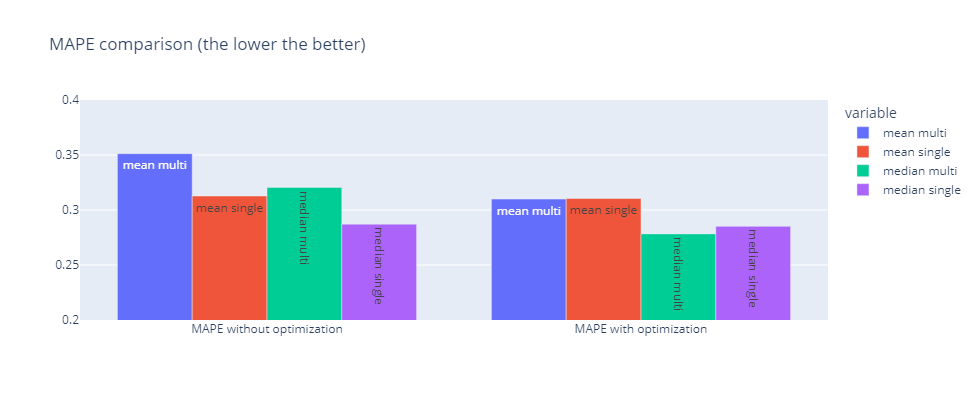

In [20]:
px.bar(res_df.loc[['MAPE without optimization', 'MAPE with optimization']], y=['mean multi', 'mean single', 'median multi', 'median single'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text='variable', range_y=[0.2, 0.4],
       title='MAPE comparison (the lower the better)')

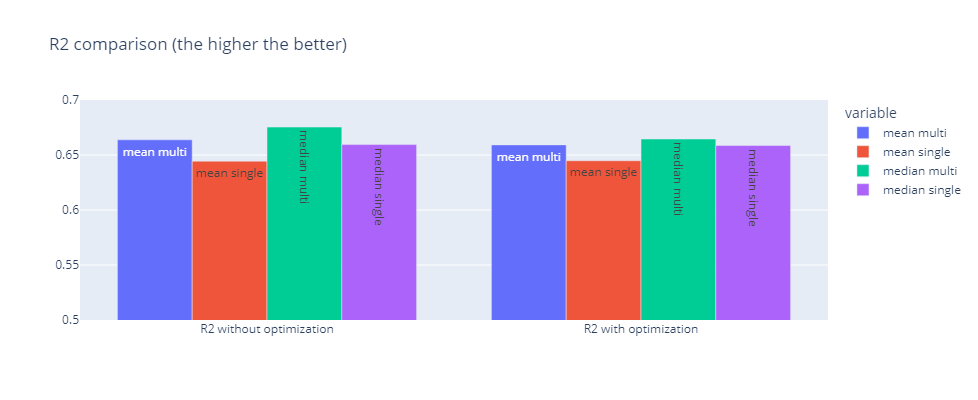

In [21]:
px.bar(res_df.loc[['R2 without optimization', 'R2 with optimization']], y=['mean multi', 'mean single', 'median multi', 'median single'], height=400,
       labels={'index':'', 'value':''}, barmode='group', text='variable', range_y=[0.5, 0.7],
       title='R2 comparison (the higher the better)')

The main takeaways of the experiments are summarized below.

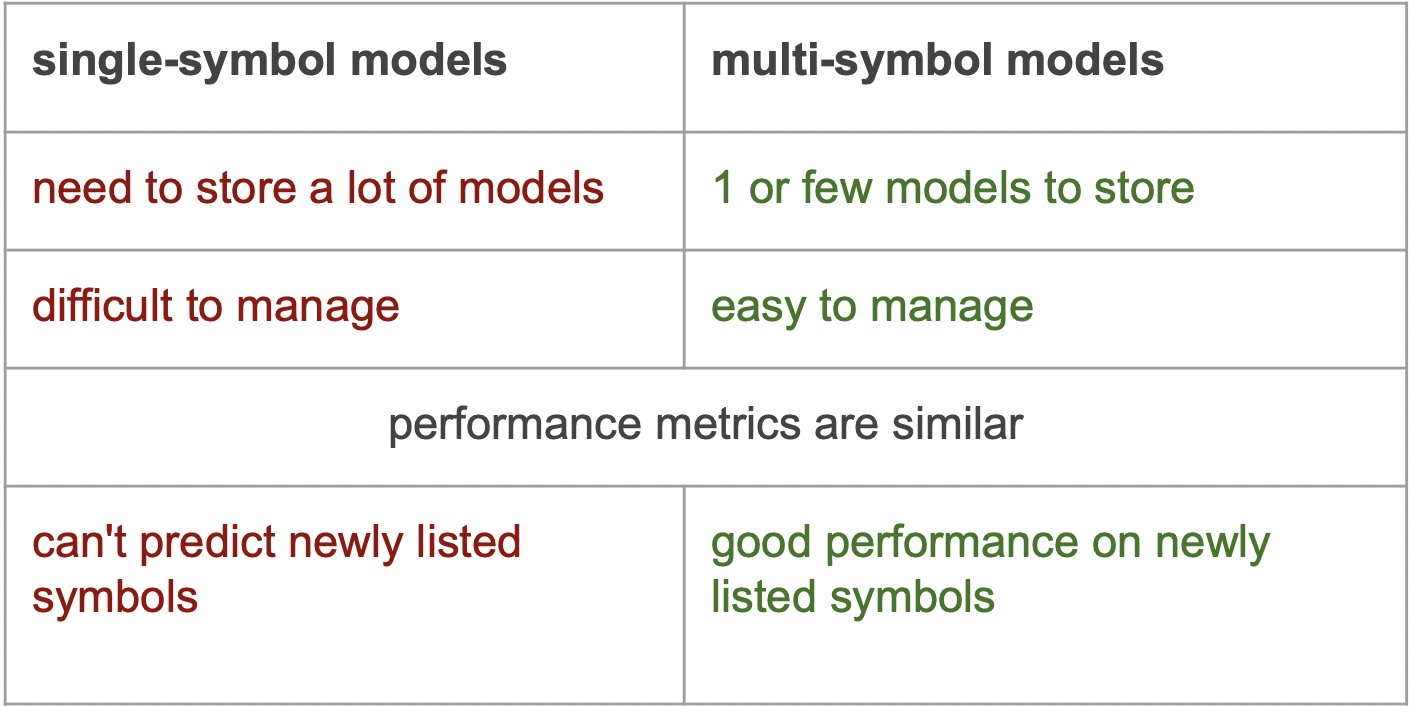

# Notes

## Other benchmarks
We intend to expand the set of benchmarks to other statistical models and in particular exponential smoothing models such as Holt-Winters.

## Other multi-series approaches
We intend to experiment with other approaches to make predictions based on multiple time series. In particular, neural net-based approaches such as the one implemented in [Darts](https://unit8.com/resources/training-forecasting-models/).

## Notebooks with source code
Coming soon.